In [1]:
#Load in the data
import numpy as np
from sklearn.utils import shuffle
from scipy import stats
from sklearn.preprocessing import LabelEncoder

X_test = np.load('/content/drive/MyDrive/Skóli/3V/Gervigreind/Lokaverkefni/time_dependant_fylki/x_test_file_2.npy')
y_test = np.load('/content/drive/MyDrive/Skóli/3V/Gervigreind/Lokaverkefni/time_dependant_fylki/y_test_file_2.npy')
X_train = np.load('/content/drive/MyDrive/Skóli/3V/Gervigreind/Lokaverkefni/time_dependant_fylki/x_train_file_2.npy')
y_train = np.load('/content/drive/MyDrive/Skóli/3V/Gervigreind/Lokaverkefni/time_dependant_fylki/y_train_file_2.npy')
X_val = np.load('/content/drive/MyDrive/Skóli/3V/Gervigreind/Lokaverkefni/time_dependant_fylki/x_val_file_2.npy')
y_val = np.load('/content/drive/MyDrive/Skóli/3V/Gervigreind/Lokaverkefni/time_dependant_fylki/y_val_file_2.npy')

enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)
y_val = enc.transform(y_val)

#Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state = 42)

In [10]:
#Create CNN model
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping

model = keras.Sequential()

# 2 LSTM layers
model.add(keras.layers.LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(256))

# dense layer
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

# output layer
model.add(keras.layers.Dense(8, activation='softmax'))


# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

callback = EarlyStopping(monitor = 'val_accuracy', patience=7, restore_best_weights=True)
# train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=30, callbacks = callback)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 259, 256)          283648    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1032      
Total params: 842,888
Trainable params: 842,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
882/882 [==============================] - 33s 35ms/step - loss: 1.7959 - accuracy: 0.3303 - val_loss: 

NameError: ignored

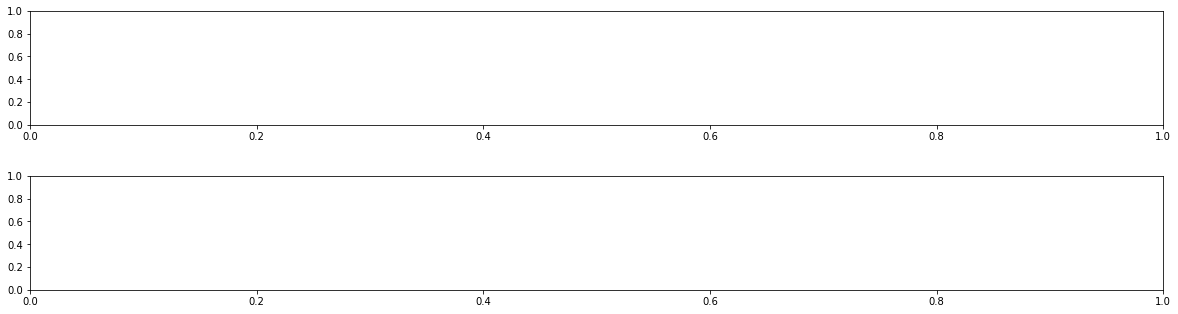

In [1]:
# Vizualize training history
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 5)

fig, axs = plt.subplots(2)
fig.tight_layout(pad=3.0)
# create accuracy sublpot
axs[0].plot(history.history["accuracy"], label="training accuracy")
axs[0].plot(history.history["val_accuracy"], label="validation accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy visualization")

# create error sublpot
axs[1].plot(history.history["loss"], label="training loss")
axs[1].plot(history.history["val_loss"], label="validation loss")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss visualization")

plt.show()

Test accuracy: 0.3768237829208374
Test loss: 1.81502103805542


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


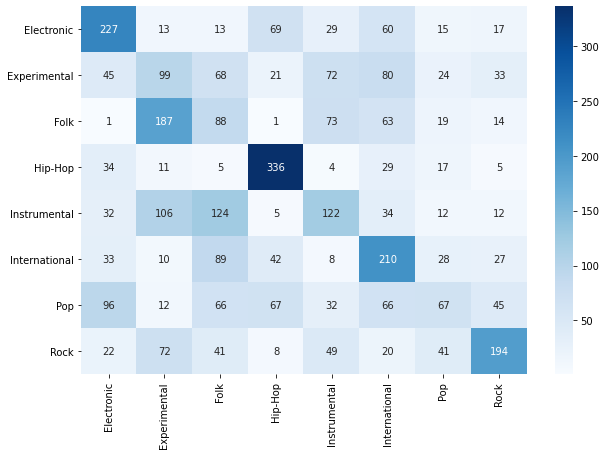

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Confusion matrix
y_pred = model.predict_classes(X_test, verbose=0)
cfm = confusion_matrix(y_test, y_pred)
df_cfm = pd.DataFrame(cfm, index = enc.classes_,
                      columns = enc.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('confusion_matrix_rnn.eps', format = 'eps')
plt.show()

In [5]:
# Create a 3D input for the CNN (similar to grayscale photos)
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

In [6]:
# Model

model = keras.Sequential()

# 1st conv layer
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(keras.layers.BatchNormalization())

# 2nd conv layer
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(keras.layers.BatchNormalization())

# 3rd conv layer
model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(216, activation='relu'))
model.add(keras.layers.Dropout(0.3))

# output layer
model.add(keras.layers.Dense(8, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
callback = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
history = model.fit(X_train_cnn, y_train, 
                    validation_data=(X_val_cnn, y_val), 
                    batch_size=32, 
                    epochs=30,
                    callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 257, 18, 128)      1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 9, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 129, 9, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 7, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 4, 128)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 4, 128)        512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 3, 128)       

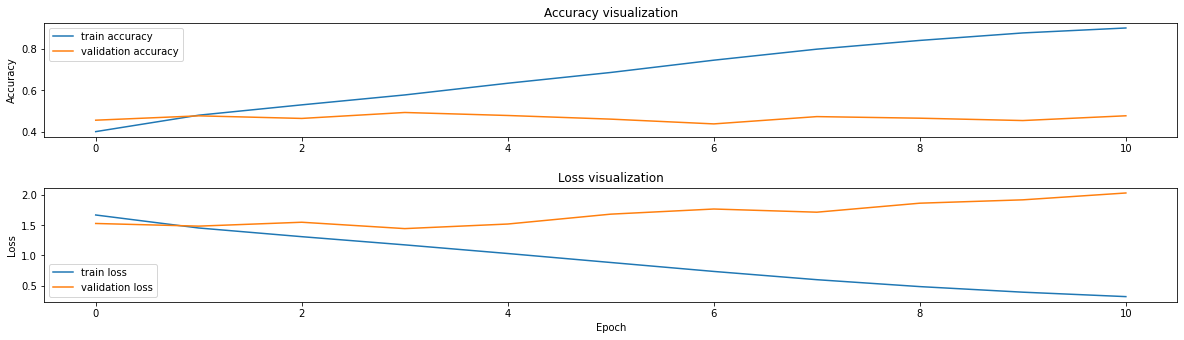

In [7]:
# Vizualize training history
fig, axs = plt.subplots(2)
fig.tight_layout(pad=3.0)

# create accuracy sublpot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="validation accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="best")
axs[0].set_title("Accuracy visualization")

# create error sublpot
axs[1].plot(history.history["loss"], label="train loss")
axs[1].plot(history.history["val_loss"], label="validation loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="best")
axs[1].set_title("Loss visualization")

plt.show()

Test accuracy: 0.38973063230514526
Test loss: 1.7443208694458008


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


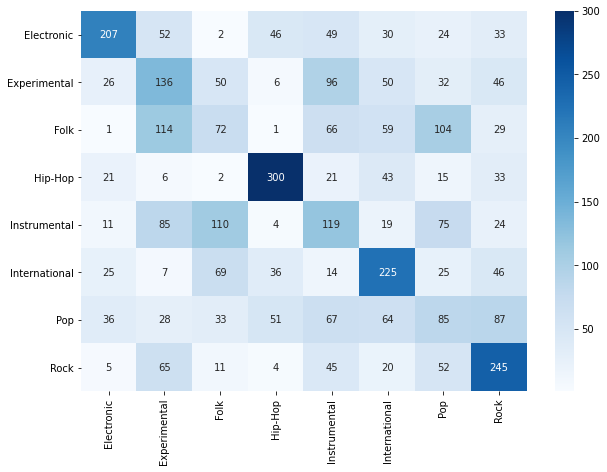

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Confusion matrix
y_pred = model.predict_classes(X_test_cnn, verbose=0)
cfm = confusion_matrix(y_test, y_pred)
df_cfm = pd.DataFrame(cfm, index = enc.classes_,
                      columns = enc.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
plt.savefig('confusion_matrix.eps', format='eps')
plt.show()
